In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lmfit import Model

plt.rcParams['axes.labelsize'] = 14   # x/y axis labels
plt.rcParams['legend.fontsize'] = 12  # legend
plt.rcParams['xtick.labelsize'] = 13  # x ticks
plt.rcParams['ytick.labelsize'] = 13  # y ticks


In [2]:
dataset_paths = [ 
    "SweepData_0.1_0.05_1000_10x10.txt",
    "SweepData_0.3_0.05_1000_10x10.txt",
    "SweepData_0.5_0.05_1000_10x10.txt",
    "SweepData_0.7_0.05_1000_10x10.txt",
    "SweepData_0.9_0.05_1000_10x10.txt",
    "SweepData_0.5_0.05_1000_4x4.txt",
    "SweepData_0.5_0.05_1000_6x6.txt",
    "SweepData_0.5_0.05_1000_8x8.txt"
]

def db_to_watts(db_values):
    return 10 ** (db_values / 10)

def watts_to_db(watts_values):
    return 10 * np.log10(watts_values)

def load_and_process_data(file_path):
    """
    Returns:
        mean_db: mean of all samples (computed in watts, then to dB)
        sem_db:  standard error of the mean, propagated into dB
        n:       total number of samples used
    """
    # Load whitespace-separated data, no header
    data = pd.read_csv(file_path, sep=r'\s+', header=None)

    # Convert dB -> W in the *same* domain you average
    data_watts = db_to_watts(data)

    # Flatten to use all samples consistently (same as averaging means twice)
    values_w = data_watts.values.ravel()
    n = values_w.size

    mean_w = np.mean(values_w)
    std_w = np.std(values_w, ddof=1) 
    sem_w = std_w / np.sqrt(n)

    mean_db = watts_to_db(mean_w)

    # Propagate SEM in watts to dB
    if mean_w > 0 and sem_w > 0:
        sem_db = (10.0 / np.log(10.0)) * (sem_w / mean_w)
    else:
        sem_db = 0.0

    return mean_db, sem_db, n
data = {
    "Loss_s": [0.0] * 8,        # mean (dB)
    "Loss_s_err": [0.0] * 8,    # SEM (dB) for error bars
    "Loss_c": [0.1, 0.3, 0.5, 0.7, 0.9, 0.5, 0.5, 0.5],
    "N": [10, 10, 10, 10, 10, 4, 6, 8],
    "n_samp": [0] * 8           # total samples used per file
}

Loss_s=pd.DataFrame(data)
for i, dataset_path in enumerate(dataset_paths):
    mean_db, sem_db, n = load_and_process_data(dataset_path)
    Loss_s.at[i, "Loss_s"] = mean_db
    Loss_s.at[i, "Loss_s_err"] = sem_db
    Loss_s.at[i, "n_samp"] = n

Loss_s

,Loss_s,Loss_s_err,Loss_c,N,n_samp
0,-0.481539,0.043075,0.1,10,10000
1,-1.442136,0.043470,0.3,10,10000
2,-2.380509,0.043880,0.5,10,10000
3,-3.325967,0.044163,0.7,10,10000
4,-4.258440,0.044607,0.9,10,10000
5,-0.837128,0.047656,0.5,4,4000
6,-1.363138,0.053384,0.5,6,6000
7,-1.889405,0.049993,0.5,8,8000


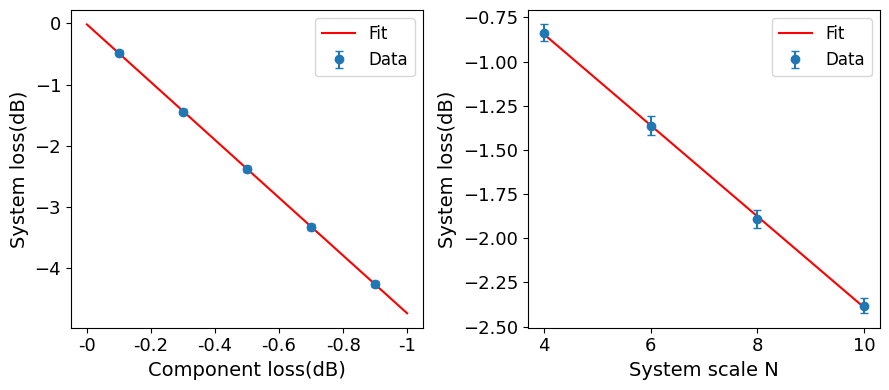

In [3]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
def linear_model(x, m, b):
    return m * x + b
model = Model(linear_model)


# First plot: Loss_s vs Loss_c (filter by N == 10)
subset1 = Loss_s[Loss_s['N'] == 10]
fit = model.fit(subset1["Loss_s"], x=subset1["Loss_c"], m=1, b=0)
x_fit = np.linspace(0, 1, 100)
y_fit = fit.eval(x=x_fit)
sns.scatterplot(data=subset1, x='Loss_c', y='Loss_s', ax=axes[0])
axes[0].plot(x_fit, y_fit, label="Fit", color="red")
axes[0].errorbar(subset1['Loss_c'], subset1['Loss_s'],
                 yerr=subset1['Loss_s_err'],
                 fmt='o', capsize=3, label='Data')
axes[0].legend()
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{-x:g}"))
axes[0].set_xlabel('Component loss(dB)')
axes[0].set_ylabel('System loss(dB)')
# Second plot: Loss_s vs N (filter by Loss_c == 0.05)
subset2 = Loss_s[Loss_s['Loss_c'] == 0.5]
fit = model.fit(subset2["Loss_s"], x=subset2["N"], m=1, b=0)
x_fit = np.linspace(4, 10, 100)
y_fit = fit.eval(x=x_fit)
sns.scatterplot(data=subset2, x='N', y='Loss_s', ax=axes[1])
plt.plot(x_fit, y_fit, label="Fit", color="red")
axes[1].errorbar(subset2['N'], subset2['Loss_s'],
                 yerr=subset2['Loss_s_err'],
                 fmt='o', capsize=3, label='Data')
axes[1].legend()
axes[1].set_xlabel('System scale N')
axes[1].set_ylabel('System loss(dB)')


# Adjust layout
plt.tight_layout()
plt.savefig("Insertion loss imperical formular.png", dpi=300, bbox_inches='tight')
plt.show()

In [4]:
import statsmodels.api as sm
y = Loss_s['Loss_s']
X = sm.add_constant(Loss_s[['Loss_c','N']])
model = sm.OLS(y, X).fit()
model.summary()

ModuleNotFoundError: No module named 'statsmodels'